In [1]:
import os
import numpy as np
import h5py
from scipy import signal
from scipy.stats import pearsonr
import seaborn as sns
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import string

data_path = ('G:/My Drive/SFARI projects/Data & Code/Ilan code and data/')

In [2]:
# Load device, cshq, and sleep diary data file:
df_dreem = pd.read_csv(data_path+'allnights_Dreem_clean.csv')
df_embrace = pd.read_csv(data_path+'allnights_Empatica_clean.csv')
df_withings = pd.read_csv(data_path+'allnights_Withings_clean.csv')
df_cshq = pd.read_csv(data_path+'df_cshq_clean.csv')
df_diary = pd.read_csv(data_path+'df_diary_clean.csv')

# Remove fields:
df_diary = df_diary.drop(columns=['Unnamed: 0'])
# Change column names:
df_diary = df_diary.rename(columns={'SO_hours': 'SO_FromMidNight', 'FA_hours': 'FA_FromMidNight'})
# Add 24 hours to FA_FromMidNight:
df_diary['FA_FromMidNight'] = df_diary['FA_FromMidNight'] + 24

# Load subject demographics:
df_demographics = pd.read_csv(data_path+'SSP_participant_demographics.csv')

print(len(df_dreem), len(df_embrace), len(df_withings), len(df_cshq), len(df_diary), len(df_demographics))

2398 2270 2957 200 2630 200


In [3]:
# Limit the analysis to overlapping nights across the devices and diary by merging datasets on subject and date columns:

# Ensure the 'date' column is in datetime format:
df_dreem['date'] = pd.to_datetime(df_dreem['date'])
df_embrace['date'] = pd.to_datetime(df_embrace['date'])
df_withings['date'] = pd.to_datetime(df_withings['date'])
df_diary['date'] = pd.to_datetime(df_diary['date'])

# Add device names to column names except for 'subject' and 'date':
exclude_columns = ['subject', 'date']

# Add suffix to all other column names
df_dreem = df_dreem.rename(columns={col: f"{col}_dreem" for col in df_dreem.columns if col not in exclude_columns})
df_embrace = df_embrace.rename(columns={col: f"{col}_embrace" for col in df_embrace.columns if col not in exclude_columns})
df_withings = df_withings.rename(columns={col: f"{col}_withings" for col in df_withings.columns if col not in exclude_columns})
df_diary = df_diary.rename(columns={col: f"{col}_diary" for col in df_diary.columns if col not in exclude_columns})



# Merge the DataFrames on 'subject' and 'date'
merged_df = pd.merge(df_dreem, df_embrace, on=['subject', 'date'], how='inner')
merged_df = pd.merge(merged_df, df_withings, on=['subject', 'date'], how='inner')
merged_df = pd.merge(merged_df, df_diary, on=['subject', 'date'], how='inner')

# Sort the final DataFrame
merged_df = merged_df.sort_values(by=['subject', 'date']).reset_index(drop=True)

# Count number of rows in the final DataFrame:
print(len(merged_df))

1142


In [4]:
# Remove children with less than 3 nights/rows of data:
data_persub = merged_df['subject'].value_counts()
sub_tokeep = data_persub[data_persub >= 3].index
merged_3nights = merged_df[merged_df['subject'].isin(sub_tokeep)]

# Count number of rows in the final DataFrame:
print(len(merged_3nights))

1100


In [5]:
# Organize data by measure:
TST_pernight = merged_3nights[['TST_dreem', 'TST_embrace', 'TST_withings', 'TST_diary']]
SO_pernight = merged_3nights[['SO_FromMidNight_dreem', 'SO_FromMidNight_embrace', 'SO_FromMidNight_withings', 'SO_FromMidNight_diary']]
FA_pernight = merged_3nights[['FA_FromMidNight_dreem', 'FA_FromMidNight_embrace', 'FA_FromMidNight_withings', 'FA_FromMidNight_diary']]
WASO_pernight = merged_3nights[['WASO_dreem', 'WASO_embrace', 'WASO_withings', 'WASO_diary']]

# Count number of rows in DataFrames:
print(len(TST_pernight), len(SO_pernight), len(FA_pernight), len(WASO_pernight))

# Compute the average per subject for selected sleep measures:
TST_bysub = merged_3nights[['subject','TST_dreem', 'TST_embrace', 'TST_withings', 'TST_diary']].groupby('subject').mean()
SO_bysub = merged_3nights[['subject','SO_FromMidNight_dreem', 'SO_FromMidNight_embrace', 'SO_FromMidNight_withings', 'SO_FromMidNight_diary']].groupby('subject').mean()
FA_bysub = merged_3nights[['subject','FA_FromMidNight_dreem', 'FA_FromMidNight_embrace', 'FA_FromMidNight_withings', 'FA_FromMidNight_diary']].groupby('subject').mean()
WASO_bysub = merged_3nights[['subject','WASO_dreem', 'WASO_embrace', 'WASO_withings', 'WASO_diary']].groupby('subject').mean()

# Organize chsq data and then merge it according to ID:
# Select only TST, WASO, SO_FromMidNight, and FA_FromMidNight columns from df_cshq:
df_cshq = df_cshq[['ID', 'TST', 'WASO', 'SO_FromMidNight', 'FA_FromMidNight']]
# Add cshq suffix to column names:
df_cshq = df_cshq.rename(columns={col: f"{col}_cshq" for col in df_cshq.columns if col != 'ID'})
TST_bysub = TST_bysub.merge(df_cshq[['ID', 'TST_cshq']], left_on='subject', right_on='ID', how='inner').drop(columns=['ID'])
SO_bysub = SO_bysub.merge(df_cshq[['ID', 'SO_FromMidNight_cshq']], left_on='subject', right_on='ID', how='inner').drop(columns=['ID'])
FA_bysub = FA_bysub.merge(df_cshq[['ID', 'FA_FromMidNight_cshq']], left_on='subject', right_on='ID', how='inner').drop(columns=['ID'])
WASO_bysub = WASO_bysub.merge(df_cshq[['ID', 'WASO_cshq']], left_on='subject', right_on='ID', how='inner').drop(columns=['ID'])

# TST_demog = TST_bysub.merge(df_demographics[['ID', 'RID', 'SPID', 'sex', 'asd', 'adhd', 'age_months', 'age_years']], left_on='subject', right_on='ID', how='inner')
# SO_demog = SO_bysub.merge(df_demographics[['ID', 'RID', 'SPID', 'sex', 'asd', 'adhd', 'age_months', 'age_years']], left_on='subject', right_on='ID', how='inner')
# FA_demog = FA_bysub.merge(df_demographics[['ID', 'RID', 'SPID', 'sex', 'asd', 'adhd', 'age_months', 'age_years']], left_on='subject', right_on='ID', how='inner')
# WASO_demog = WASO_bysub.merge(df_demographics[['ID', 'RID', 'SPID', 'sex', 'asd', 'adhd', 'age_months', 'age_years']], left_on='subject', right_on='ID', how='inner')

# # Count number of rows in DataFrames:
# print(len(TST_demog), len(SO_demog), len(FA_demog), len(WASO_demog))
# # Count number of autistic kids and sibling:
# print(len(TST_demog[TST_demog['asd'] == 1]), len(TST_demog[TST_demog['asd'] == 0]))

1100 1100 1100 1100


In [18]:
# Define a function to calculate Concordance Correlation Coefficient (CCC)
def concordance_correlation_coefficient(x, y):
    mean_x, mean_y = np.mean(x), np.mean(y)
    var_x, var_y = np.var(x), np.var(y)
    covariance = np.cov(x, y, ddof=1)[0, 1]
    ccc = (2 * covariance) / (var_x + var_y + (mean_x - mean_y) ** 2)
    return ccc

# Define a function to calculate CCC statistical significance using a randomization analysis:
def random_ccc_percentile(x, y, iterations=5000, percentile=99.9):
    # Initialize an empty list to store randomized CCC values
    ccc_values = []

    for _ in range(iterations):
        # Randomize the order of y
        randomized_y = np.random.permutation(y)
        # Compute CCC for randomized x and y
        ccc = concordance_correlation_coefficient(x, randomized_y)
        ccc_values.append(ccc)

    # Compute the desired percentile from the distribution
    return np.percentile(ccc_values, percentile)

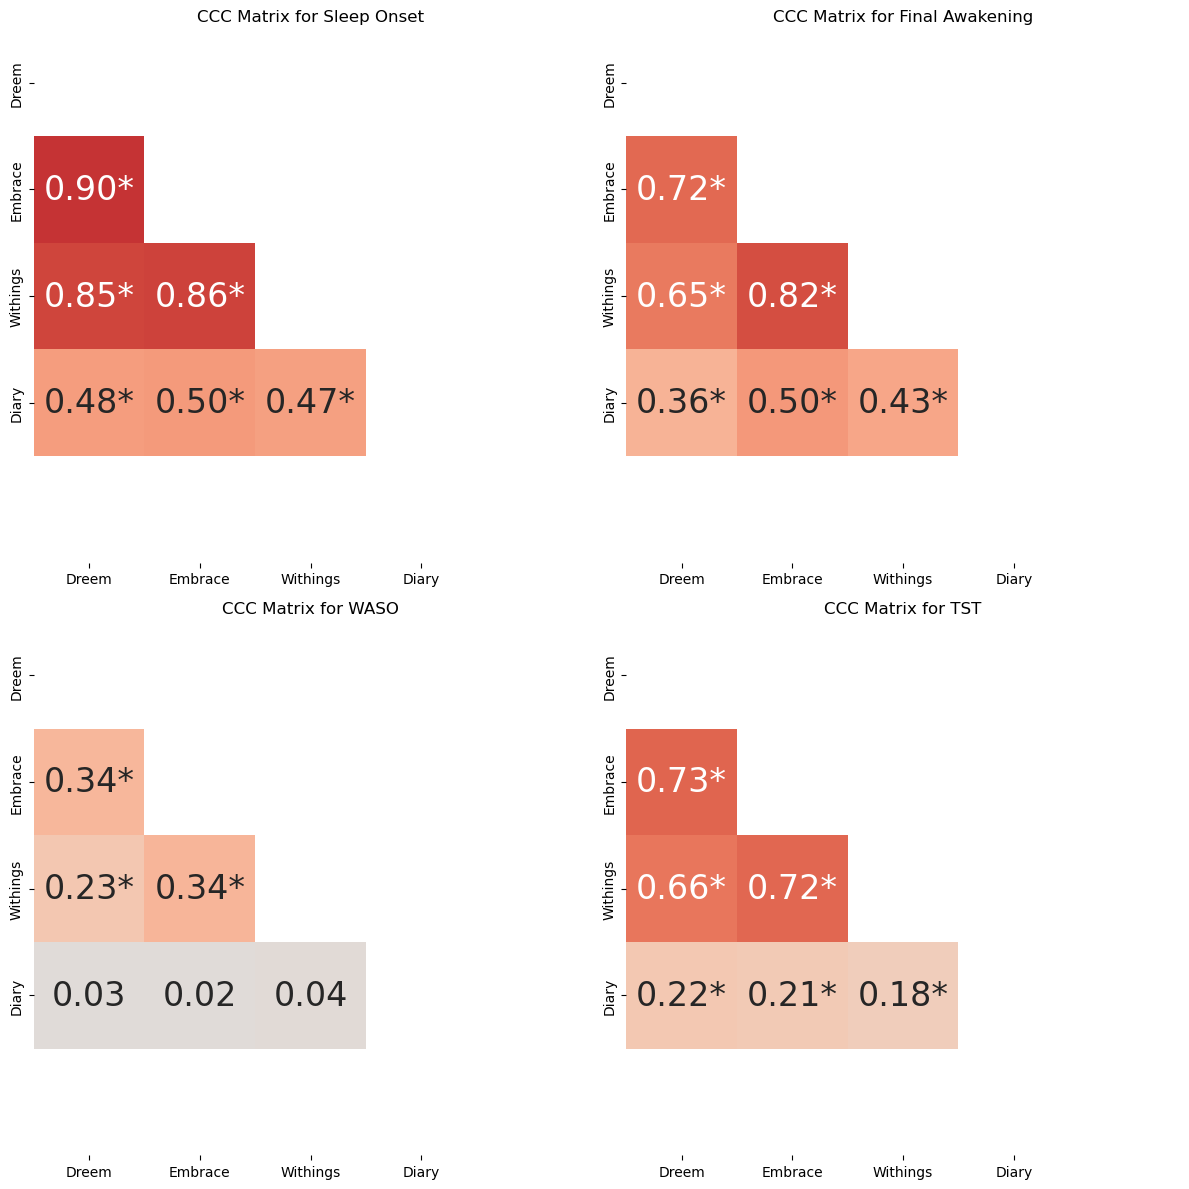

In [20]:
# List of measures and their corresponding DataFrames
measures = {
    "Sleep Onset": SO_pernight,
    "Final Awakening": FA_pernight,
    "WASO": WASO_pernight,
    "TST": TST_pernight
}

device_labels = ['Dreem', 'Embrace', 'Withings', 'Diary'] 

# Create heatmaps for each measure
plt.figure(figsize=(12, 12))  # Adjust figure size
for i, (measure, df) in enumerate(measures.items(), 1):
    # Initialize CCC matrix (3x3)
    n = df.shape[1]
    ccc_matrix = np.zeros((n, n))
    annotations = np.empty((n, n), dtype=object)  # Annotation matrix for significance
    
    # Calculate pairwise CCC
    for row in range(n):
        for col in range(n):
            if row != col:  # Avoid diagonal computation if not needed
                sig_thresh = random_ccc_percentile(df.iloc[:, row], df.iloc[:, col])
                # print(f"Significance threshold for {measure} between {device_labels[row]} and {device_labels[col]}: {sig_thresh:.2f}")
                ccc_value = concordance_correlation_coefficient(df.iloc[:, row], df.iloc[:, col])
                ccc_matrix[row, col] = ccc_value
                annotations[row, col] = f"{ccc_value:.2f}" + ("*" if abs(ccc_value) > sig_thresh else "")
            else:
                ccc_matrix[row, col] = 1.0  # Perfect agreement with itself
    
    # Expand to 4x4 with zeros in the extra row/column
    expanded_matrix = np.zeros((5, 5))
    expanded_annotations = np.full((5, 5), "", dtype=object)  # Expanded annotation matrix
    expanded_matrix[:4, :4] = ccc_matrix  # Copy the original 3x3 matrix
    expanded_annotations[:4, :4] = annotations  # Copy annotations
    
    # Create a mask to hide the upper triangle and the extra row/column
    mask = np.ones_like(expanded_matrix, dtype=bool)
    mask[:4, :4] = np.triu(np.ones_like(ccc_matrix, dtype=bool))  # Only top-left 3x3 block has values

    # Plot heatmap
    plt.subplot(2, 2, i)
    sns.heatmap(expanded_matrix, mask=mask, annot=expanded_annotations, cmap="coolwarm", cbar=False, 
                vmin=-1, vmax=1, fmt="", annot_kws={"size": 24},  # fmt="" since annotations are preformatted
                xticklabels=device_labels, yticklabels=device_labels)
    plt.title(f"CCC Matrix for {measure}")
    
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

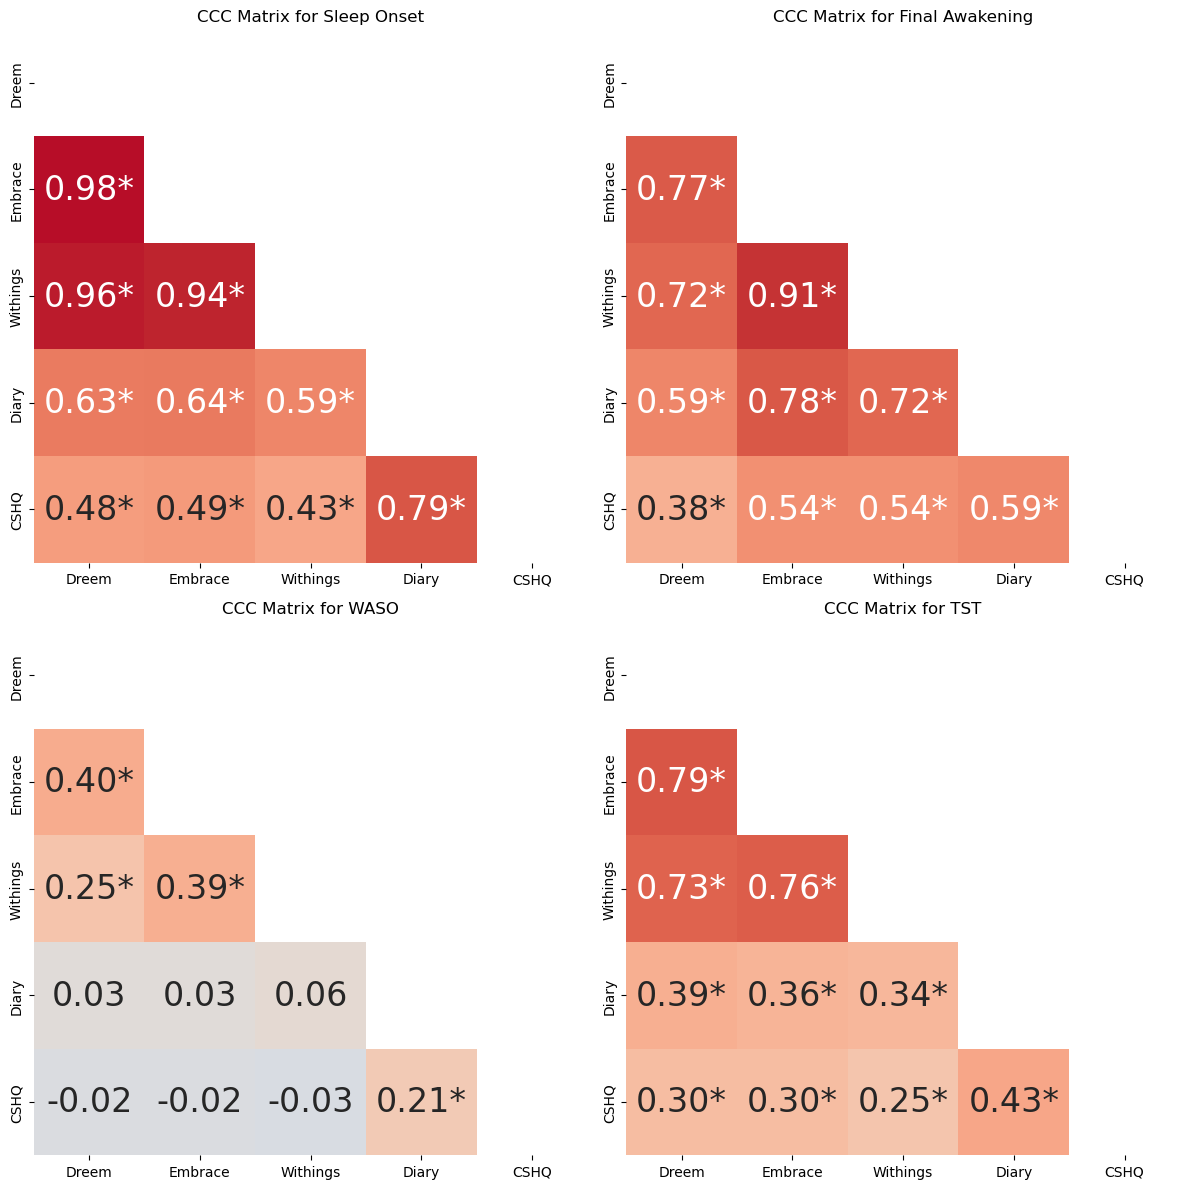

In [24]:
# List of measures and their corresponding DataFrames
measures = {
    "Sleep Onset": SO_bysub,
    "Final Awakening": FA_bysub,
    "WASO": WASO_bysub,
    "TST": TST_bysub
}
device_labels = ['Dreem', 'Embrace', 'Withings', 'Diary', 'CSHQ'] 

# Create heatmaps for each measure
plt.figure(figsize=(12, 12))  # Adjust figure size
for i, (measure, df) in enumerate(measures.items(), 1):
    # Initialize CCC matrix
    n = df.shape[1]
    ccc_matrix = np.zeros((n, n))
    annotations = np.empty((n, n), dtype=object)  # Annotation matrix for significance
    
    # Calculate pairwise CCC
    for row in range(n):
        for col in range(n):
            if row != col:  # Avoid diagonal computation if not needed
                sig_thresh = random_ccc_percentile(df.iloc[:, row], df.iloc[:, col])
                # print(f"Significance threshold for {measure} between {device_labels[row]} and {device_labels[col]}: {sig_thresh:.2f}")
                ccc_value = concordance_correlation_coefficient(df.iloc[:, row], df.iloc[:, col])
                ccc_matrix[row, col] = ccc_value
                annotations[row, col] = f"{ccc_value:.2f}" + ("*" if abs(ccc_value) > sig_thresh else "")
            else:
                ccc_matrix[row, col] = 1.0  # Perfect agreement with itself
    
    # Create a mask to hide the upper triangle and diagonal
    mask = np.triu(np.ones_like(ccc_matrix, dtype=bool))
    
    # Plot heatmap
    plt.subplot(2, 2, i)
    sns.heatmap(ccc_matrix, mask=mask, annot=annotations, cmap="coolwarm", cbar=False, 
                vmin=-1, vmax=1, fmt="", annot_kws={"size": 24},
                xticklabels=device_labels, yticklabels=device_labels)
    plt.title(f"CCC Matrix for {measure}")
    

# Adjust layout and show the plot
plt.tight_layout()
plt.show()